In [5]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from matplotlib.legend_handler import HandlerLine2D


'''
NANOG-GATA6-FOXA2-FOXF1 MODEL with combined protein and rna
Model C V1: Add 2 I1-FFLs to regulate FOXF1 and FOXA2 production. I1-FFLs are "pulse generators" that differentially respond to
different production rates.
In this system, FOXF1 is activated at at low GATA6 and inhibited at high GATA6 via a noncompetitive inhibition function,
FOXA2 is activated by GATA6
We observe few differences in dgata6 due to the dominating hill-like equation in the system
'''

def dNANOG(NANOG, GATA6, a1, a2, a3, n, m, KM_NN, KM_GN):
    return (a1 + (a2 * NANOG ** n)/(KM_NN ** n + NANOG ** n)) * (KM_GN ** m)/(KM_GN ** m + GATA6 ** m) - a3 * NANOG

def dGATA6(GATA6, NANOG, dox, p, a1, a2, n, m, KM_GG, KM_NG):
    return dox * p + (a1 * GATA6 ** n)/(KM_GG ** n + GATA6 ** n) * (KM_NG ** m)/(KM_NG ** m + NANOG ** m) - a2 * GATA6

def dFFLI(Y1, GATA6, a1, a2, n, KM_G):
    return (a1 * GATA6 ** n)/(KM_G ** n + GATA6 ** n) - a2 * Y1

def dFOXA2(FOXA2, FOXF1, GATA6, Y1, a1, a2, a3, n, m, o, p, KM_G, KM_Y, KM_A2, KM_F1):
    #+ (a2 * FOXA2 ** o)/(KM_A2 ** o + FOXA2 ** o) * (KM_F1 ** p / KM_F1 ** p + FOXF1 ** p)
    return (a1 * GATA6 ** n)/(KM_G ** n + GATA6 **n) * (KM_Y ** m) / (KM_Y ** m + Y1 ** m)  - a3 * FOXA2

def dFOXF1(FOXF1, FOXA2, GATA6, Y1, a1, a2, a3, n, m, o, p, KM_G, KM_Y, KM_A2, KM_F1):
    # + (a2 * FOXF1 ** o)/(KM_F1 ** o + FOXF1 ** o) * (KM_A2 ** p / KM_A2 ** p + FOXA2 ** p)
    return (a1 * GATA6 ** n)/(KM_G ** n + GATA6 **n) * (KM_Y ** m) / (KM_Y ** m + Y1 ** m)  - a3 * FOXF1

def dudt(U, t, dox, p, parameters):
    """
    TO DO: Figure out if we should do a reduction of parameters in our system for analysis
    """
    NANOG, GATA6, Y1, FOXA2, FOXF1 = U
    a1, a2, a3, an, am, KM_NN, KM_GN = parameters['NANOG']
    b1, b2, bn, bm, KM_GG, KM_NG = parameters['GATA6']
    c1, c2, cn, KM_YG = parameters['Y1']
    d1, d2, d3, dn, dm, do, dp, KM_AG, KM_AY, KM_AA, KM_AF = parameters['FOXA2']
    e1, e2, e3, en, em, eo, ep, KM_FG, KM_FY, KM_FA, KM_FF = parameters['FOXF1']
    
    d = 0
    if t > 12:
        d = dox 
    dNANOG_dt = dNANOG(NANOG, GATA6, a1, a2, a3, an, am, KM_NN, KM_GN)
    dGATA6_dt = dGATA6(GATA6, NANOG, d, p, b1, b2, bn, bm, KM_GG, KM_NG)
    dY1_dt = dFFLI(Y1, GATA6, c1, c2, cn, KM_YG)
    dFOXA2_dt = dFOXA2(FOXA2, FOXF1, GATA6, NANOG, d1, d2, d3, dn, dm, do, dp, KM_AG, KM_AY, KM_AA, KM_AF)
    dFOXF1_dt = dFOXF1(FOXF1, FOXA2, GATA6, NANOG, e1, e2, e3, en, em, eo, ep, KM_FG, KM_FY, KM_FA, KM_FF)
    return dNANOG_dt, dGATA6_dt, dY1_dt, dFOXA2_dt, dFOXF1_dt



In [24]:
dox = np.arange(0, 1, 0.1)
value = 0.8

tf = 240
t = np.arange(0, tf, 1)
num_cells = 1000

K_MA = 20
K_MF = 10

parameters = {}
parameters['NANOG'] = [3.5, 4, 0.5, 3.5, 1.5, 5, 5]
parameters['GATA6'] = [8, 0.5, 0.7, 2.5, 5, 5]
parameters['Y1'] = [4, 0.5, 4, 15]
parameters['FOXA2'] = [2, 8, 0.5, 4, 4, 0.7, 2.5, K_MA, 5, 5, 5]
parameters['FOXF1'] = [2, 4, 0.5, 4, 4, 3.5, 1.5, K_MF, 5, 5, 5]

p = np.random.uniform(2, 16)
print(p)
NANOG = np.random.normal(15)
GATA6 = np.random.rand() * 0.15
FOXA2 = 0.0
FOXF1 = 0.0
PROTY = 0.0
U = np.array([NANOG, GATA6, PROTY, FOXA2, FOXF1])
nanog_values = [U[0]]
gata6_values = [U[1]]
foxa2_values = [U[3]]
foxf1_values = [U[4]]
proty_values = [U[2]]
for time in t:
    U += dudt(U, time, value, p, parameters)
    nanog_values.append(U[0])
    gata6_values.append(U[1])
    proty_values.append(U[2])
    foxa2_values.append(U[3])
    foxf1_values.append(U[4])

14.115311498812957


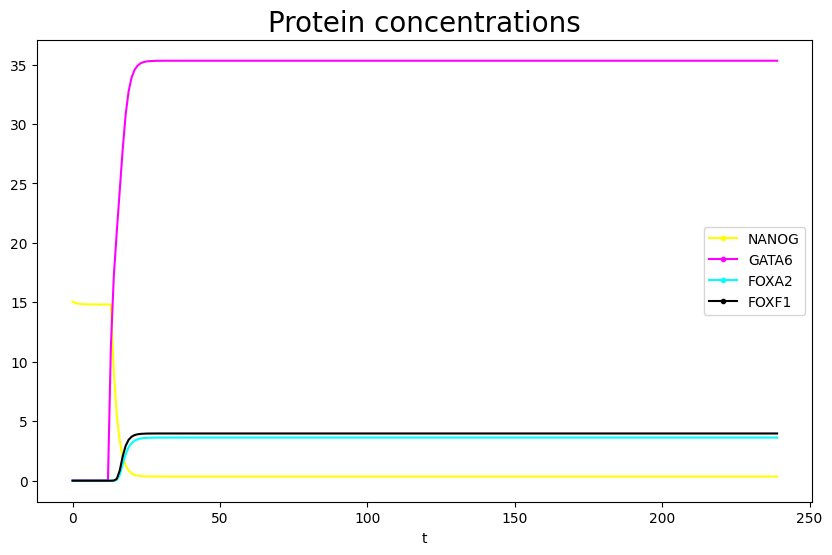

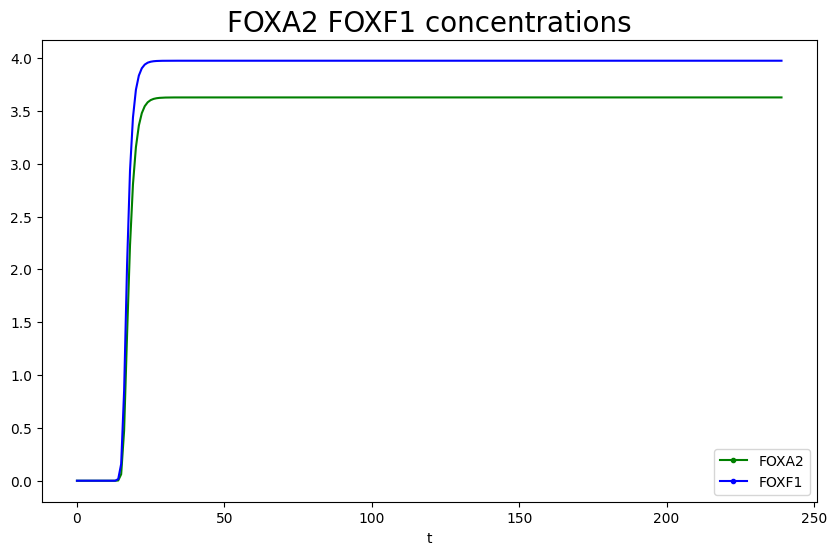

In [25]:
def change_alpha(handle, original):
    ''' Change the alpha and marker style of the legend handles '''
    handle.update_from(original)
    handle.set_alpha(1)
    handle.set_marker('.')

fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.plot(t, nanog_values[1:], color='yellow', alpha=1)
ax.plot(t, gata6_values[1:], color ='magenta', alpha=1)
ax.plot(t, foxa2_values[1:], color='cyan', alpha=1)
ax.plot(t, foxf1_values[1:], color='black', alpha=1)
ax.set_title(f'Protein concentrations', fontsize=20)
ax.set_xlabel('t')
plt.legend(['NANOG', 'GATA6', 'FOXA2', 'FOXF1'], handler_map={plt.Line2D: HandlerLine2D(update_func=change_alpha)})   

    
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.plot(t, foxa2_values[1:], color='g', alpha=1)
ax.plot(t, foxf1_values[1:], color ='blue', alpha=1)
ax.set_title(f'FOXA2 FOXF1 concentrations', fontsize=20)
ax.set_xlabel('t')
plt.legend(['FOXA2', 'FOXF1'], handler_map={plt.Line2D: HandlerLine2D(update_func=change_alpha)})